## Initial Exploration

Objective: How  well  can  we  classify  a  restaurant’s  cuisine  type  using  the 
content of their reviews as input?

### Imports and Preprocessing

In [54]:
import multilabel_classification_functions

import pandas as pd
import numpy as np
import os
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

import regex as re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics


In [6]:
reviews = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/10k_reviews.csv')
restaurants = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/105_restaurants.csv')

In [ ]:
# Drops unnecessary columns
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures', 'Rating'], axis=1, inplace=True)

restaurants.drop(['Links', 'Cost', 'Collections', 'Timings'], axis=1, inplace=True)

# Merges the cuisines column with the reviews
reviews = reviews.merge(restaurants[['Name', 'Cuisines']], 
                                      left_on='Restaurant', right_on='Name', 
                                      how='left').drop(columns=['Name'])

reviews.drop(['Restaurant'], axis=1, inplace=True)

# Only the needed columns now
reviews.head()

Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   
3  Soumen das and Arun was a great guy. Only beca...   
4  Food is good.we ordered Kodi drumsticks and ba...   

                                            Cuisines  
0  Chinese, Continental, Kebab, European, South I...  
1  Chinese, Continental, Kebab, European, South I...  
2  Chinese, Continental, Kebab, European, South I...  
3  Chinese, Continental, Kebab, European, South I...  
4  Chinese, Continental, Kebab, European, South I...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    9955 non-null   object
 1   Cuisines  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


None

### Structure and null rows

In [8]:
# Checking null rows
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    9955 non-null   object
 1   Cuisines  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [10]:
reviews.dropna(subset=['Review'], inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9955 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    9955 non-null   object
 1   Cuisines  9955 non-null   object
dtypes: object(2)
memory usage: 233.3+ KB


### Sentence Structure

In [13]:
# Creating dummy columns for message length and number of sentences
reviews["msg_len"] = reviews["Review"].map(lambda content : len(str(content)))

sent_tokenizer = PunktSentenceTokenizer()
reviews["sents"] = reviews["Review"].map(lambda content :\
                                                                  sent_tokenizer.tokenize(str(content)))
reviews["nr_sents"] = reviews["sents"].map(lambda content : len(content))
reviews.describe()

msg_len     nr_sents
count  9955.000000  9955.000000
mean    279.774485     4.067403
std     338.598799     4.236098
min       1.000000     1.000000
25%     144.000000     1.000000
50%     189.000000     3.000000
75%     321.000000     5.000000
max    5212.000000    66.000000

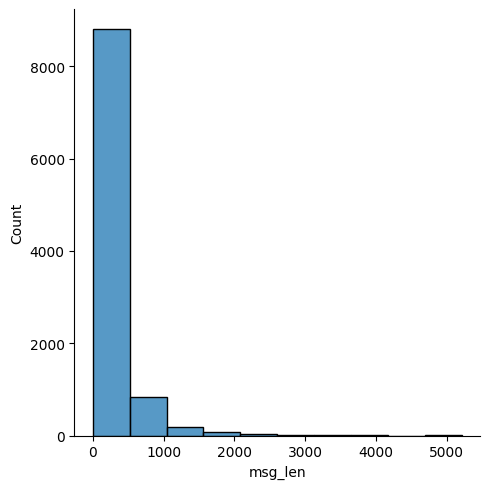

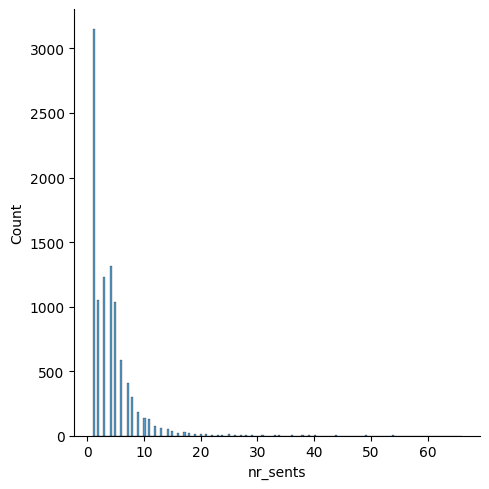

In [16]:
# Plotting results
sns.displot(reviews["msg_len"], log_scale=False, bins=10)
sns.displot(reviews["nr_sents"])

### Class Balance

In [18]:
## Convert the labels column to a list of labels

reviews["Cuisines"] = reviews["Cuisines"].map(lambda content : re.split(",",re.sub("\s","",content)))

In [19]:
## Extract the unique cuisines

unique_cuisines = []

for cuisines_list in list(reviews["Cuisines"]):
    for cuisine in cuisines_list:
        if cuisine not in unique_cuisines:
            unique_cuisines.append(cuisine)

unique_cuisines

['Chinese',
 'Continental',
 'Kebab',
 'European',
 'SouthIndian',
 'NorthIndian',
 'Biryani',
 'Asian',
 'Mediterranean',
 'Desserts',
 'Seafood',
 'Beverages',
 'Goan',
 'HealthyFood',
 'Lebanese',
 'American',
 'IceCream',
 'StreetFood',
 'FastFood',
 'BBQ',
 'Italian',
 'FingerFood',
 'Burger',
 'Japanese',
 'Salad',
 'Sushi',
 'Mexican',
 'Mughlai',
 'Andhra',
 'Bakery',
 'Juices',
 'Arabian',
 'Hyderabadi',
 'Cafe',
 'Spanish',
 'Wraps',
 'Thai',
 'Indonesian',
 'ModernIndian',
 'Momos',
 'Pizza',
 'NorthEastern']

In [ ]:
# Create a scratch dataset - "reviews_explore" - to plot the number of movies by label and to generate TF-IDF word clouds by label

reviews_explore = pd.DataFrame()
reviews_explore["Review"] = reviews["Review"]

for label in unique_cuisines:
    reviews_explore["has_label_{}".format(label)] = reviews["Cuisines"].map(lambda labels_list : 1 if label in labels_list else 0)

reviews_explore.describe()

has_label_Chinese  has_label_Continental  has_label_Kebab  \
count        9955.000000            9955.000000      9955.000000   
mean            0.411351               0.209342         0.060271   
std             0.492103               0.406859         0.238001   
min             0.000000               0.000000         0.000000   
25%             0.000000               0.000000         0.000000   
50%             0.000000               0.000000         0.000000   
75%             1.000000               0.000000         0.000000   
max             1.000000               1.000000         1.000000   

       has_label_European  has_label_SouthIndian  has_label_NorthIndian  \
count         9955.000000            9955.000000            9955.000000   
mean             0.040181               0.090407               0.602210   
std              0.196393               0.286778               0.489466   
min              0.000000               0.000000               0.000000   
25%              0.000000               0.000000               0.000000   
50%              0.000000               0.000000               1.000000   
75%              0.000000               0.000000               1.000000   
max              1.000000               1.000000               1.000000   

       has_label_Biryani  has_label_Asian  has_label_Mediterranean  \
count        9955.000000      9955.000000              9955.000000   
mean            0.150477         0.140633                 0.050226   
std             0.357556         0.347660                 0.218422   
min             0.000000         0.000000                 0.000000   
25%             0.000000         0.000000                 0.000000   
50%             0.000000         0.000000                 0.000000   
75%             0.000000         0.000000                 0.000000   
max             1.000000         1.000000                 1.000000   

       has_label_Desserts  ...  has_label_Hyderabadi  has_label_Cafe  \
count         9955.000000  ...           9955.000000     9955.000000   
mean             0.130487  ...              0.040080        0.060271   
std              0.336856  ...              0.196158        0.238001   
min              0.000000  ...              0.000000        0.000000   
25%              0.000000  ...              0.000000        0.000000   
50%              0.000000  ...              0.000000        0.000000   
75%              0.000000  ...              0.000000        0.000000   
max              1.000000  ...              1.000000        1.000000   

       has_label_Spanish  has_label_Wraps  has_label_Thai  \
count        9955.000000      9955.000000     9955.000000   
mean            0.010045         0.010045        0.020090   
std             0.099726         0.099726        0.140317   
min             0.000000         0.000000        0.000000   
25%             0.000000         0.000000        0.000000   
50%             0.000000         0.000000        0.000000   
75%             0.000000         0.000000        0.000000   
max             1.000000         1.000000        1.000000   

       has_label_Indonesian  has_label_ModernIndian  has_label_Momos  \
count           9955.000000             9955.000000      9955.000000   
mean               0.010045                0.020090         0.040181   
std                0.099726                0.140317         0.196393   
min                0.000000                0.000000         0.000000   
25%                0.000000                0.000000         0.000000   
50%                0.000000                0.000000         0.000000   
75%                0.000000                0.000000         0.000000   
max                1.000000                1.000000         1.000000   

       has_label_Pizza  has_label_NorthEastern  
count      9955.000000             9955.000000  
mean          0.009945                0.010045  
std           0.099231                0.099726  
min           0.000000                0.000

<Axes: >

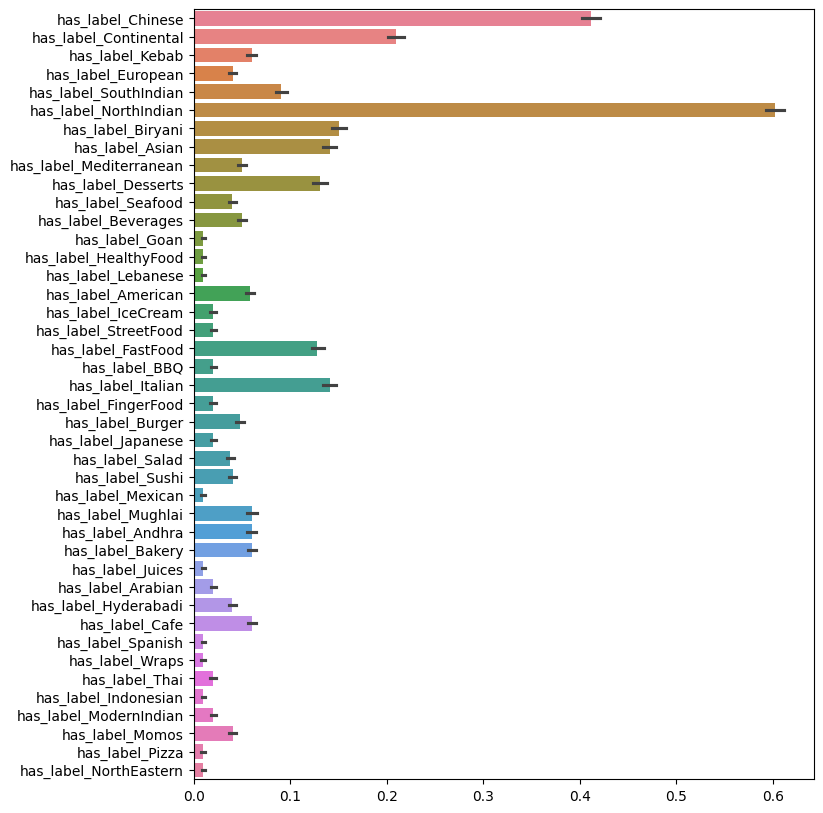

In [33]:
## Plot the number of reviews by cuisine
plt.figure(figsize=(8, 10))
sns.barplot(reviews_explore, orient="h")

### Word Visualizations

In [46]:
def word_freq_calculator(td_matrix, word_list, df_output=True):
    word_counts = np.sum(td_matrix, axis=0).tolist()
    if df_output == False:
        word_counts_dict = dict(zip(word_list, word_counts))
        return word_counts_dict
    else:
        word_counts_df = pd.DataFrame({"words":word_list, "frequency":word_counts})
        word_counts_df = word_counts_df.sort_values(by=["frequency"], ascending=False)
        return word_counts_df

def plot_term_frequency(df, nr_terms, df_name, show=True):
    
    # Create the Seaborn bar plot
    plt.figure(figsize=(10, 8))
    sns_plot = sns.barplot(x='frequency', y='words', data=df.head(nr_terms))  # Plotting top 20 terms for better visualization
    plt.title('Top 20 Term Frequencies of {}'.format(df_name))
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    if show==True:
        plt.show()

    fig = sns_plot.get_figure()
    plt.close()

    return fig

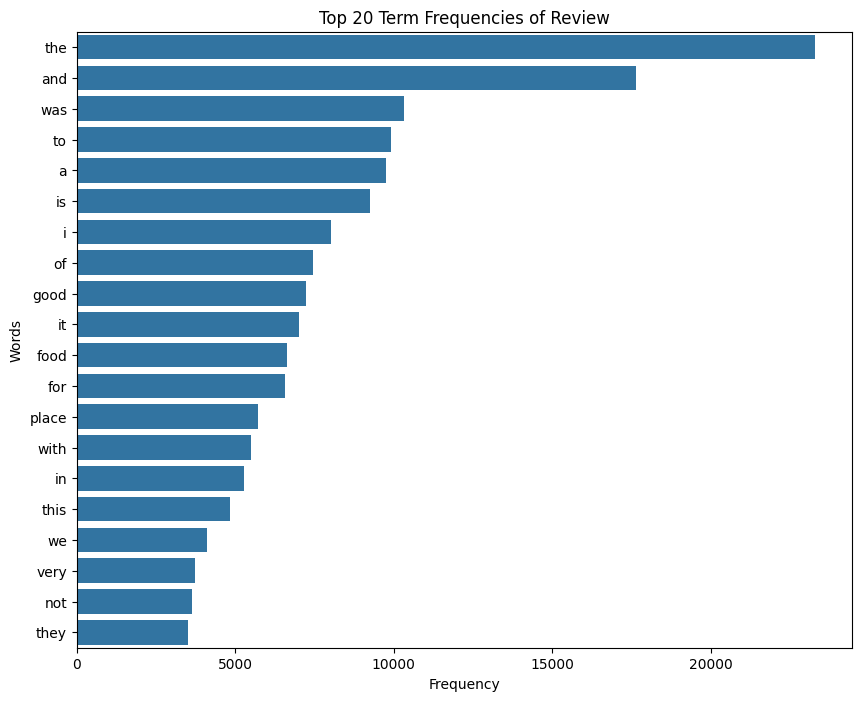

In [47]:
# Plot the 20 most common words by vectorising the raw content using bigram BoW

bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  

reviews_bow_td_matrix = bigram_bow_vectorizer.fit_transform(reviews["Review"]).toarray()
reviews_bow_word_list = bigram_bow_vectorizer.get_feature_names_out()

reviews_raw_vocabulary_df = word_freq_calculator(reviews_bow_td_matrix,\
                                                                      reviews_bow_word_list, df_output=True)
plot_term_frequency(reviews_raw_vocabulary_df, 20, "Review", show=False)

In [52]:
from collections import defaultdict, Counter
from tqdm import tqdm
from unidecode import unidecode
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import BaseEstimator

class MainPipeline(BaseEstimator):
    def __init__(self, 
                 print_output = False, 
                 no_emojis = True, 
                 no_hashtags = True,
                 hashtag_retain_words = True,
                 no_newlines = True,
                 no_urls = True,
                 no_punctuation = True,
                 no_stopwords = True,
                 custom_stopwords = [],
                 convert_diacritics = True, 
                 lowercase = True, 
                 lemmatized = True,
                 list_pos = ["n","v","a","r","s"],
                 pos_tags_list = "no_pos",
                 tokenized_output = False):
        
        self.print_output = print_output 
        self.no_emojis = no_emojis
        self.no_hashtags = no_hashtags
        self.hashtag_retain_words = hashtag_retain_words
        self.no_newlines = no_newlines
        self.no_urls = no_urls
        self.no_punctuation = no_punctuation
        self.no_stopwords = no_stopwords
        self.custom_stopwords = custom_stopwords
        self.convert_diacritics = convert_diacritics
        self.lowercase = lowercase
        self.lemmatized = lemmatized
        self.list_pos = list_pos
        self.pos_tags_list = pos_tags_list
        self.tokenized_output = tokenized_output

    def regex_cleaner(self, raw_text):

        #patterns
        newline_pattern = "(\\n)"
        hashtags_at_pattern = "([#\@@\u0040\uFF20\uFE6B])"
        hashtags_ats_and_word_pattern = "([#@]\w+)"
        emojis_pattern = "([\u2600-\u27FF])"
        url_pattern = "(?:\w+:\/{2})?(?:www)?(?:\.)?([a-z\d]+)(?:\.)([a-z\d\.]{2,})(\/[a-zA-Z\/\d]+)?" ##Note that this URL pattern is *even better*
        punctuation_pattern = "[\u0021-\u0026\u0028-\u002C\u002E-\u002F\u003A-\u003F\u005B-\u005F\u007C\u2010-\u2028\ufeff`]+"
        apostrophe_pattern = "'(?=[A-Z\s])|(?<=[a-z\.\?\!\,\s])'"
        separated_words_pattern = "(?<=\w\s)([A-Z]\s){2,}"
        ##note that this punctuation_pattern doesn't capture ' this time to allow our tokenizer to separate "don't" into ["do", "n't"]
        
        if self.no_emojis == True:
            clean_text = re.sub(emojis_pattern,"",raw_text)
        else:
            clean_text = raw_text

        if self.no_hashtags == True:
            if self.hashtag_retain_words == True:
                clean_text = re.sub(hashtags_at_pattern,"",clean_text)
            else:
                clean_text = re.sub(hashtags_ats_and_word_pattern,"",clean_text)
            
        if self.no_newlines == True:
            clean_text = re.sub(newline_pattern," ",clean_text)

        if self.no_urls == True:
            clean_text = re.sub(url_pattern,"",clean_text)
        
        if self.no_punctuation == True:
            clean_text = re.sub(punctuation_pattern,"",clean_text)
            clean_text = re.sub(apostrophe_pattern,"",clean_text)

        return clean_text

    def lemmatize_all(self, token):
    
        wordnet_lem = nltk.stem.WordNetLemmatizer()
        for arg_1 in self.list_pos[0]:
            token = wordnet_lem.lemmatize(token, arg_1)
        return token

    def main_pipeline(self, raw_text):
        
        """Preprocess strings according to the parameters"""
        if self.print_output == True:
            print("Preprocessing the following input: \n>> {}".format(raw_text))

        clean_text = self.regex_cleaner(raw_text)

        if self.print_output == True:
            print("Regex cleaner returned the following: \n>> {}".format(clean_text))

        tokenized_text = nltk.tokenize.word_tokenize(clean_text)

        tokenized_text = [re.sub("'m","am",token) for token in tokenized_text]
        tokenized_text = [re.sub("n't","not",token) for token in tokenized_text]
        tokenized_text = [re.sub("'s","is",token) for token in tokenized_text]

        if self.no_stopwords == True:
            stopwords = nltk.corpus.stopwords.words("english")
            tokenized_text = [item for item in tokenized_text if item.lower() not in stopwords]
        
        if self.convert_diacritics == True:
            tokenized_text = [unidecode(token) for token in tokenized_text]

        if self.lemmatized == True:
            tokenized_text = [self.lemmatize_all(token) for token in tokenized_text]
    
        if self.no_stopwords == True:
            tokenized_text = [item for item in tokenized_text if item.lower() not in self.custom_stopwords]

        if self.pos_tags_list == "pos_list" or self.pos_tags_list == "pos_tuples" or self.pos_tags_list == "pos_dictionary":
            pos_tuples = nltk.tag.pos_tag(tokenized_text)
            pos_tags = [pos[1] for pos in pos_tuples]
        
        if self.lowercase == True:
            tokenized_text = [item.lower() for item in tokenized_text]
        
        if self.pos_tags_list == "pos_list":
            return (tokenized_text, pos_tags)
        elif self.pos_tags_list == "pos_tuples":
            return pos_tuples   
        
        else:
            if self.tokenized_output == True:
                return tokenized_text
            else:
                detokenizer = TreebankWordDetokenizer()
                detokens = detokenizer.detokenize(tokenized_text)
                if self.print_output == True:
                    print("Pipeline returning the following result: \n>> {}".format(str(detokens)))
                return str(detokens)

In [55]:
## Prepare the scratch dataset for word cloud generation by using the main pipeline function with all preprocessing parameters set to True

preprocessor = MainPipeline(print_output=True)

reviews_explore["Preproc_review"] =\
      reviews_explore["Review"].map(lambda content : preprocessor.main_pipeline(content))

Preprocessing the following input: 
>> The ambience was good, food was quite good . had Saturday lunch , which was cost effective .
Good place for a sate brunch. One can also chill with friends and or parents.
Waiter Soumen Das was really courteous and helpful.
Regex cleaner returned the following: 
>> The ambience was good food was quite good  had Saturday lunch  which was cost effective  Good place for a sate brunch One can also chill with friends and or parents Waiter Soumen Das was really courteous and helpful
Pipeline returning the following result: 
>> ambience good food quite good saturday lunch cost effective good place sate brunch one also chill friend parent waiter soumen das really courteous helpful
Preprocessing the following input: 
>> Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service
Regex cleaner returned the following: 
>> Ambience is too good for a pleasant evening Service is

In [ ]:
## Prepare a corpus of documents, so that each document consists of the concatenated reviews for each cuisine

corpus = []
for label in unique_cuisines:
    label_doc = ""
    for review in reviews_explore["Preproc_review"].loc[reviews_explore["has_label_{}".format(label)]==1]:        
        label_doc = label_doc + " " + review
    corpus.append(label_doc)

print("Length of unique_cuisines: {}; Length of corpus: {}".format(len(unique_cuisines), len(corpus)))

Length of unique_cuisines: 42; Length of corpus: 42


In [57]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

In [58]:
## Generate word clouds for each genre label from the TF-IDF vectorisation of the corpus, storing the results in the "word_clouds" folder 

folder_path = "word_clouds"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for idx, document in enumerate(corpus):
    genre_corpus_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(corpus)
    genre_corpus_tfidf_word_list = bigram_tfidf_vectorizer.get_feature_names_out()

    genre_corpus_vocabulary = word_freq_calculator(genre_corpus_tfidf_td_matrix[idx].toarray(),\
                                                                        genre_corpus_tfidf_word_list, df_output=False)
    wc.generate_from_frequencies(genre_corpus_vocabulary)
    wc.to_file(os.path.join(folder_path, "WC_"+unique_cuisines[idx]+"TFIDF.png"))

## Insights

- **Null rows** - There are 45 rows with empty reviews. We dropped these, consideing they made up less than 0.5% of data.
- **Sentence structure** - Review length varies between 1 and 5212 characters, the avergae being 280 characters. It is noteworthy that the 75th percentile is of 321 charcaters, this may indicate some outliers (exceptionally long reviews). In terms of sentences, the reviews have between 1 and 66 sentences, average of 4, with the same issue of the 75th percentile being 5, pssibly showing outliers. This is more clearly seen in the graphs, where the vast majority of reviews tend to be smaller and with less sentences.
- **Class balance** - There is clear class imbalance in the datatset. North Indian is by far the most common cuisine, with Chinese at second place. The most under-represented cuisines are Goan, Healthy Food, Lebanese, Mexican, Juices, Spanish, Wraps, Pizza, and North Eastern. This makes sense due to the geolocation of the restaurants in question. We should expect good performance from the model in the North Indian and Chinese cuisines, and will try to optiize considering this imbalance by using weighted measures.
- **Word occurence** - In the top 20, the only non-stopwords present are "good", "food", "place" and "very". This makes sense, given the reviews are often talking about the restaurant's food, and that not only the good, but also the bad reviews include "good" (as in not good) and "very" (as in very bad)
- **Class uniqueness** - Upon analysing the word clouds, we can see that some cuisiens will be easier to identify due to having unique words. This is the case of Bakery, Beverages, Cafe, Desserts, Ice Cream (very identifiable), North Eastern and Wraps. On the other hand, we can expect worse performance on the cuisines that are less unique, like Adhra, Asian, BBQ, Chinese, Italian or Kebab, among others.